In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score # recall scorer
from sklearn.metrics import precision_score # precision scorer
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import f1_score # f1
import itertools


# SVM for multi-class classification using one-vs-one
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier

# logistic regression for multi-class classification using a one-vs-rest
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import os
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec 
from gensim.models import KeyedVectors
from scipy import spatial

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
print('Number of data points : ', df.shape[0])
print('Number of features : ', df.shape[1])
df.head()

Number of data points :  2072
Number of features :  9


,Unnamed: 0,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,590,Having made a massive impact in Saudi Arabia w...,Having made a massive impact in Saudi Arabia w...,"['singhs', 'rooting', 'cool', 'saudi', 'style'...",NaN,[],https://www.msn.com/en-in/entertainment/other/...,cricket,sports
1,388,Cricket is all about the emotional rollercoast...,"No matter which team fans hope to win, every s...","['wants', 'fans', 'finals', 'cup', 'win', 'tou...",NaN,[],https://www.prnewswire.com:443/news-releases/c...,cricket,sports
2,423,New Zealand announces back-to-back tours next ...,New Zealand announces back-to-back tours next ...,"['test', 'west', 'tour', 'zealand', 'world', '...",2021-12-20 00:00:00,[],https://www.aljazeera.com/news/2021/12/20/cric...,cricket,sports
3,563,It's not the first time cricket fans in the co...,Billed as one of the pre-tournament favourites...,"['qualify', 'afghanistan', 'cup', 'world', 'ze...",NaN,[],https://www.msn.com/en-in/news/other/t20-world...,cricket,sports
4,634,An employee works on a computer terminal again...,"REUTERS/Sivaram VBENGALURU, Oct 11 (Reuters Br...","['success', 'tech', 'startup', 'talent', 'onli...",2021-10-11 00:00:00,['Una Galani'],https://www.reuters.com/breakingviews/india-in...,cricket,sports


In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label","leaf_label"]], test_size=0.2)

In [5]:
print('Number of data points in train data:', train.shape[0])
print('Number of data points in test data:', test.shape[0])

Number of data points in train data: 1657
Number of data points in test data: 415


In [6]:
train

,full_text,root_label,leaf_label
415,"GREEN BAY, Wis. — Bears return man Jakeem Gran...",sports,football
1702,"Businesses, area economy as a whole benefit fr...",climate,earthquake
832,"Trust, engagement, accountability and mindfuln...",sports,chess
1026,"The International Chess Federation, the game’s...",sports,chess
1621,The earthquake was reported around 9:24 p.m. S...,climate,earthquake
...,...,...,...
757,"By Zachary Zagger (November 2, 2021, 4:01 PM E...",sports,soccer
1637,By Michael Susin\n\nTremor International Ltd. ...,climate,earthquake
1338,"Some people like the foliage, others enjoy the...",climate,flood
1549,NEW HAVEN — A nor’easter brought rain and wind...,climate,flood


In [7]:
test

,full_text,root_label,leaf_label
703,PARIS (AP) — Human rights activists in France ...,sports,soccer
247,"Bangladesh's Liton Das, right, gestures to Sri...",sports,cricket
1329,© Provided by Mid-Day\n\nTravellers who are fu...,climate,flood
1054,Dr Ron Edwards completing his term as State Re...,climate,%22forest%20fire%22
1200,Santa Barbara’s year-round sunshine and good w...,climate,%22forest%20fire%22
...,...,...,...
222,The hub will redefine the role of tech in lear...,sports,cricket
320,The Texas Longhorns went into Waco with the ho...,sports,football
1930,3 Ways To Increase Water Reuse In Industrial F...,climate,drought
135,Cases against students of two medical colleges...,sports,cricket


In [8]:
#"chess": 0, "cricket": 1, "soccer": 2,"football":3,"%22forest%20fire%22":4,"flood":5,"earthquake":6,"drought":7
y_train_encoded = train["leaf_label"].copy()
y_test_encoded = test["leaf_label"].copy()


y_train_encoded[y_train_encoded == 'chess'] = 0
y_test_encoded[y_test_encoded == 'chess'] = 0


y_train_encoded[y_train_encoded== 'cricket'] = 1
y_test_encoded[y_test_encoded == 'cricket'] = 1

y_train_encoded[y_train_encoded == 'soccer'] = 2
y_test_encoded[y_test_encoded == 'soccer'] = 2

y_train_encoded[y_train_encoded == 'football'] = 3
y_test_encoded[y_test_encoded == 'football'] = 3

y_train_encoded[y_train_encoded == '%22forest%20fire%22'] = 4
y_test_encoded[y_test_encoded == '%22forest%20fire%22'] = 4

y_train_encoded[y_train_encoded == 'flood'] = 5
y_test_encoded[y_test_encoded == 'flood'] = 5

y_train_encoded[y_train_encoded == 'earthquake'] = 6
y_test_encoded[y_test_encoded == 'earthquake'] = 6

y_train_encoded[y_train_encoded == 'drought'] = 7
y_test_encoded[y_test_encoded == 'drought'] = 7

print("Training Set\n")
print("Original train_dataset:\n" + str(train["leaf_label"][0:20]))
print("\nBinarized train_dataset:\n" + str(y_train_encoded[0:20]))
print("\nTest Set\n")
print("Original test_dataset:\n" + str(test["leaf_label"][0:20]))
print("\nBinarized test_dataset:\n" + str(y_test_encoded[0:20]))

Training Set

Original train_dataset:
415                football
1702             earthquake
832                   chess
1026                  chess
1621             earthquake
851                   chess
1535                  flood
1440                  flood
313                football
823                   chess
1005                  chess
1267    %22forest%20fire%22
1323                  flood
2026                drought
448                football
1190    %22forest%20fire%22
2025                drought
1326                  flood
188                 cricket
1242    %22forest%20fire%22
Name: leaf_label, dtype: object

Binarized train_dataset:
415     3
1702    6
832     0
1026    0
1621    6
851     0
1535    5
1440    5
313     3
823     0
1005    0
1267    4
1323    5
2026    7
448     3
1190    4
2025    7
1326    5
188     1
1242    4
Name: leaf_label, dtype: object

Test Set

Original test_dataset:
703                  soccer
247                 cricket
1329                  

In [11]:
train['encoded'] = y_train_encoded.astype(str).astype(int)

In [10]:
test['encoded'] = y_test_encoded.astype(str).astype(int)

In [23]:
train = train.sort_values(by = 'encoded')


In [24]:
test = test.sort_values(by = 'encoded')

In [28]:
train.head()

,full_text,root_label,leaf_label,encoded
1012,Citrusw00d Productions unveils films minted as...,sports,chess,0
814,Dec. 25 is fast approaching so I browsed the b...,sports,chess,0
956,Raissa Bretaña studies history through a fashi...,sports,chess,0
892,© Manjunath KIRAN Magnus Carlsen (R) is pictur...,sports,chess,0
987,Kenya Tong-Il Moo Do Federation president Clar...,sports,chess,0


In [29]:
test.head()

,full_text,root_label,leaf_label,encoded
921,"US Chess Championships R3: Caruana, Sevian Joi...",sports,chess,0
980,Dave Chappelle is considered an inspiration to...,sports,chess,0
854,"For many chess fans, the just-completed world ...",sports,chess,0
830,"Today in History\n\nToday is Tuesday, Nov. 30,...",sports,chess,0
813,We’ve talked in-depth about who the best chess...,sports,chess,0


In [30]:
import re
def clean(text):
    text = re.sub(r"http\S+", '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub(r"[0-9]","", texter)
    texter = re.sub('[^a-zA-Z0-9\n]', ' ', texter)
    texter = re.sub('\s+',' ', texter)
    texter = texter.lower()
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [31]:
train['full_text'] = train['full_text'].apply(clean)
test['full_text'] = test['full_text'].apply(clean)

In [33]:
train.head()

,full_text,root_label,leaf_label,encoded
1012,citruswd productions unveils films minted as n...,sports,chess,0
814,dec is fast approaching so i browsed the booth...,sports,chess,0
956,raissa breta a studies history through a fashi...,sports,chess,0
892,manjunath kiran magnus carlsen r is pictured ...,sports,chess,0
987,kenya tong il moo do federation president clar...,sports,chess,0


In [34]:
test.head()

,full_text,root_label,leaf_label,encoded
921,us chess championships r caruana sevian join l...,sports,chess,0
980,dave chappelle is considered an inspiration to...,sports,chess,0
854,for many chess fans the just completed world c...,sports,chess,0
830,today in history today is tuesday nov the th d...,sports,chess,0
813,we ve talked in depth about who the best chess...,sports,chess,0


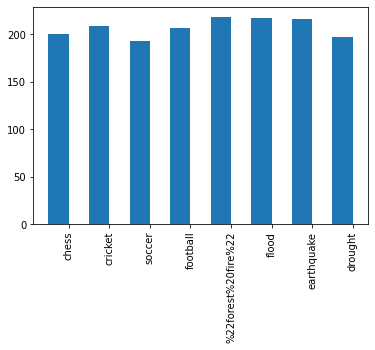

In [35]:
counter = Counter(train['leaf_label'])
leaf_names = counter.keys()
leaf_counts = counter.values()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(leaf_names))
plt.bar(indexes, leaf_counts, 0.5)
plt.xticks(indexes + 0.5 * 0.5, leaf_names, rotation=90)
plt.show()

In [36]:
print("Number of distributions per leaf label in Train : ",leaf_counts)

Number of distributions per leaf label in Train :  dict_values([200, 209, 193, 207, 218, 217, 216, 197])


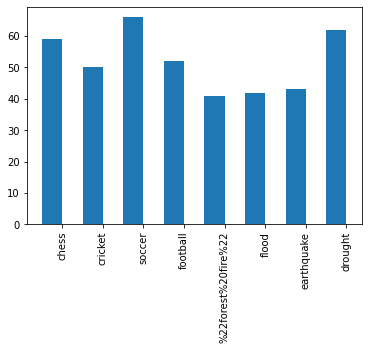

In [37]:
counter = Counter(test['leaf_label'])
leaf_names = counter.keys()
leaf_counts = counter.values()

# Plot histogram using matplotlib bar().
indexes = np.arange(len(leaf_names))
plt.bar(indexes, leaf_counts, 0.5)
plt.xticks(indexes + 0.5 * 0.5, leaf_names, rotation=90)
plt.show()

In [38]:
print("Number of distributions per leaf label in test: ", leaf_counts)

Number of distributions per leaf label in test:  dict_values([59, 50, 66, 52, 41, 42, 43, 62])


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import pos_tag
from pickle import dump

counts = []

wnl = nltk.wordnet.WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]


def rmv_nums(doc):
    #gets rid of numbers including floats
    #does lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
    return (word for word in lemmatize_sent(analyzer(doc)) 
            if not word.isdigit())

#CountVectorizer returns a callable that handles preprocessing and tokenization
#Use the “english” stopwords of the CountVectorizer
vectorizer=CountVectorizer(analyzer=rmv_nums,min_df=5,stop_words='english')

#do feature extraction (train):
X_train_counts=vectorizer.fit_transform(train["full_text"]) #get matrix of doc-term counts (training data)
print('Size of training data after lemmatization but before TF-IDF: ', X_train_counts.shape) 
X_test_counts=vectorizer.transform(test["full_text"]) 
print('Size of testing data after lemmatization but before TF-IDF:  ', X_test_counts.shape) 

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print('Shape of train TF-IDF matrix: ',X_train_tfidf.shape)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print('Shape of test TF-IDF matrix:  ',X_test_tfidf.shape)

Size of training data after lemmatization but before TF-IDF:  (1657, 6982)
Size of testing data after lemmatization but before TF-IDF:   (415, 6982)
Shape of train TF-IDF matrix:  (1657, 6982)
Shape of test TF-IDF matrix:   (415, 6982)


In [40]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42, n_iter = 10)
X_train_LSI = svd.fit_transform(X_train_tfidf)
X_test_LSI = svd.transform(X_test_tfidf)
print('LSI train:')
print(X_train_LSI.shape)
print('LSI test:')
print(X_test_LSI.shape)

LSI train:
(1657, 50)
LSI test:
(415, 50)


In [41]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=50, init = 'random', random_state=42, max_iter=1000)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)
print('NMF train:')
print(X_train_NMF.shape)
print('NMF test:')
print(X_test_NMF.shape)

NMF train:
(1657, 50)
NMF test:
(415, 50)


In [42]:
X_multi_train = [X_train_tfidf.toarray(), X_train_LSI, X_train_NMF]
y_multi_train = train["leaf_label"]
X_multi_test = [X_test_tfidf.toarray(), X_test_LSI, X_test_NMF]
y_multi_test = test["leaf_label"]

In [54]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = []
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Multiclass NaiveBayes TFIDF Confusion matrix: 

Confusion matrix, without normalization
[[35  0  0  1  3  1  0  1]
 [ 0 51  1  0  2  1  1  3]
 [ 0  6 44  0  0  0  0  0]
 [10  3  0 44  3  2  0  0]
 [ 3  6  0  0 28  4  1  1]
 [ 4  0  0  2  5 29  1  1]
 [ 1  1  2  0  0  0 42  6]
 [ 3 10  5  0  2  1  5 40]]


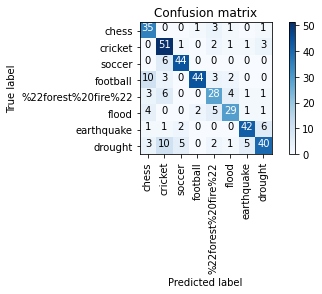

Multiclass NaiveBayes TFIDF Accuracy Score: 0.7542168674698795
Multiclass NaiveBayes TFIDF Recall Score: 0.7542168674698795
Multiclass NaiveBayes TFIDF Precision Score: 0.7542168674698795
Multiclass NaiveBayes TFIDF f1 Score: 0.7542168674698795
Multiclass NaiveBayes LSI Confusion matrix: 

Confusion matrix, without normalization
[[37  2  0  0  1  0  1  0]
 [ 0 55  0  0  1  2  1  0]
 [ 0  4 44  0  0  0  1  1]
 [ 3  0  0 51  5  1  2  0]
 [ 3  3  0  0 34  1  2  0]
 [ 0  2  2  2 10 25  0  1]
 [ 0  0  1  0  1  0 50  0]
 [ 0  7  1  0  2  1  6 49]]


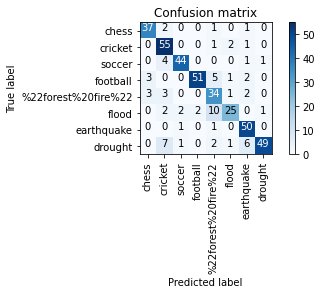

Multiclass NaiveBayes LSI Accuracy Score: 0.8313253012048193
Multiclass NaiveBayes LSI Recall Score: 0.8313253012048193
Multiclass NaiveBayes LSI Precision Score: 0.8313253012048193
Multiclass NaiveBayes LSI f1 Score: 0.8313253012048193
Multiclass NaiveBayes NMF Confusion matrix: 

Confusion matrix, without normalization
[[37  1  0  1  0  2  0  0]
 [ 0 52  1  0  2  2  2  0]
 [ 0  4 45  0  1  0  0  0]
 [ 2  1  0 53  0  5  1  0]
 [ 3  1  1  0 31  6  1  0]
 [ 0  2  0  2  6 30  1  1]
 [ 0  1  0  0  0  0 49  2]
 [ 0  2  2  0  1  1  2 58]]


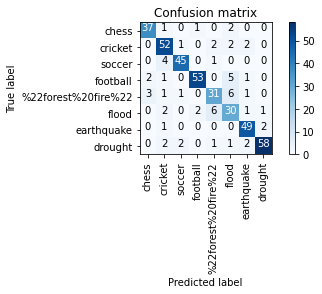

Multiclass NaiveBayes NMF Accuracy Score: 0.8554216867469879
Multiclass NaiveBayes NMF Recall Score: 0.8554216867469879
Multiclass NaiveBayes NMF Precision Score: 0.8554216867469879
Multiclass NaiveBayes NMF f1 Score: 0.8554216867469879


In [56]:
from sklearn.naive_bayes import GaussianNB
# Naive Bayes
multiclass_NB = GaussianNB()
classes = ['chess', "cricket", "soccer","football","%22forest%20fire%22","flood","earthquake",'drought']
labels = ['TFIDF', 'LSI', 'NMF'] # LSI, NMF
for idx, x in enumerate(X_multi_train):
    if (idx < len(labels)):
        #if (labels[idx] == 'N/A'):
            #multiclass_NB.fit(lsi_scaled[0], y_multi)
            #multiclass_NB_pred = multiclass_NB.predict(lsi_scaled[1])
        #else:
            # train model
        multiclass_NB.fit(x, y_multi_train)
            # get test results
        multiclass_NB_pred = multiclass_NB.predict(X_multi_test[idx])
        multiclass_NB_confusion = confusion_matrix(y_true=y_multi_test, y_pred=multiclass_NB_pred)
        multiclass_NB_accuracy = accuracy_score(y_true=y_multi_test, y_pred=multiclass_NB_pred)
        multiclass_NB_recall = recall_score(y_true=y_multi_test, y_pred=multiclass_NB_pred, average='micro')
        multiclass_NB_precision = precision_score(y_true=y_multi_test, y_pred=multiclass_NB_pred, average='micro')
        multiclass_NB_f1 = f1_score(y_true=y_multi_test, y_pred=multiclass_NB_pred, average='micro')
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(multiclass_NB_confusion, classes = classes)
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Accuracy Score: " + str(multiclass_NB_accuracy))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Recall Score: " + str(multiclass_NB_recall))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Precision Score: " + str(multiclass_NB_precision))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " f1 Score: " + str(multiclass_NB_f1))

In [57]:
# Multiclass SVM classification
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
multiclass_svm_OvO = OneVsOneClassifier(SVC(random_state=42))
multiclass_svm_OvR = OneVsRestClassifier(SVC(random_state=42))

Multiclass SVM OvO TFIDF Confusion matrix: 

Confusion matrix, without normalization
[[40  0  1  0  0  0  0  0]
 [ 0 56  0  0  0  1  1  1]
 [ 0  3 47  0  0  0  0  0]
 [ 4  0  0 56  1  1  0  0]
 [ 2  3  0  0 37  0  1  0]
 [ 1  2  1  1  3 32  1  1]
 [ 0  1  0  0  0  0 51  0]
 [ 0  5  0  0  1  0  1 59]]


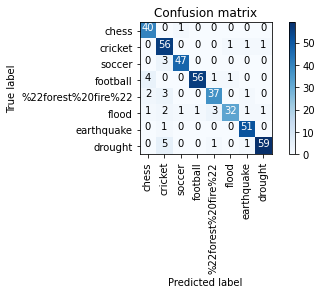

Multiclass SVM OvO TFIDF Accuracy Score: 0.9108433734939759
Multiclass SVM OvO TFIDF Recall Score: 0.9108433734939759
Multiclass SVM OvO TFIDF Precision Score: 0.9108433734939759
Multiclass SVM OvO TFIDF f1 Score: 0.9108433734939759
Multiclass SVM OvO LSI Confusion matrix: 

Confusion matrix, without normalization
[[38  2  0  0  0  1  0  0]
 [ 0 57  0  0  0  1  1  0]
 [ 0  4 46  0  0  0  0  0]
 [ 1  2  0 58  0  1  0  0]
 [ 2  3  0  0 35  2  1  0]
 [ 0  3  1  2  3 31  1  1]
 [ 0  2  0  0  0  0 50  0]
 [ 0  8  0  0  0  1  2 55]]


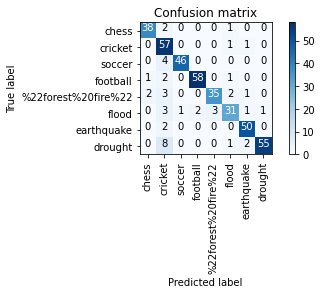

Multiclass SVM OvO LSI Accuracy Score: 0.891566265060241
Multiclass SVM OvO LSI Recall Score: 0.891566265060241
Multiclass SVM OvO LSI Precision Score: 0.891566265060241
Multiclass SVM OvO LSI f1 Score: 0.891566265060241
Multiclass SVM OvO NMF Confusion matrix: 

Confusion matrix, without normalization
[[37  2  0  0  0  2  0  0]
 [ 0 53  1  0  2  2  1  0]
 [ 0  5 45  0  0  0  0  0]
 [ 1  1  0 57  1  2  0  0]
 [ 1  5  0  1 30  5  1  0]
 [ 1  4  0  2  4 29  1  1]
 [ 0  2  1  0  0  0 49  0]
 [ 0  5  1  0  2  2  2 54]]


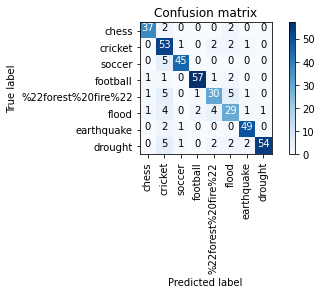

Multiclass SVM OvO NMF Accuracy Score: 0.8530120481927711
Multiclass SVM OvO NMF Recall Score: 0.8530120481927711
Multiclass SVM OvO NMF Precision Score: 0.8530120481927711
Multiclass SVM OvO NMF f1 Score: 0.8530120481927711


In [58]:
labels = ['TFIDF', 'LSI', 'NMF'] #, 'LSI', 'NMF'
classes = ['chess', "cricket", "soccer","football","%22forest%20fire%22","flood","earthquake",'drought']
for idx, x in enumerate(X_multi_train):
    if (idx < len(labels)):
        # train model
        multiclass_svm_OvO.fit(x, y_multi_train)
        # get test results
        multiclass_svm_OvO_pred = multiclass_svm_OvO.predict(X_multi_test[idx])
        multiclass_svm_OvO_confusion = confusion_matrix(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred)
        multiclass_svm_OvO_accuracy = accuracy_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred)
        multiclass_svm_OvO_recall = recall_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred, average='micro')
        multiclass_svm_OvO_precision = precision_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred, average='micro')
        multiclass_svm_OvO_f1 = f1_score(y_true=y_multi_test, y_pred=multiclass_svm_OvO_pred, average='micro')
        print("Multiclass SVM OvO " + labels[idx] + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(multiclass_svm_OvO_confusion, classes = classes)
        print("Multiclass SVM OvO " + labels[idx] + " Accuracy Score: " + str(multiclass_svm_OvO_accuracy))
        print("Multiclass SVM OvO " + labels[idx] + " Recall Score: " + str(multiclass_svm_OvO_recall))
        print("Multiclass SVM OvO " + labels[idx] + " Precision Score: " + str(multiclass_svm_OvO_precision))
        print("Multiclass SVM OvO " + labels[idx] + " f1 Score: " + str(multiclass_svm_OvO_f1))


Multiclass SVM OvR TFIDF Confusion matrix: 

Confusion matrix, without normalization
[[39  0  1  0  1  0  0  0]
 [ 0 56  0  0  0  1  1  1]
 [ 0  3 47  0  0  0  0  0]
 [ 2  0  0 59  0  1  0  0]
 [ 2  2  0  0 37  0  1  1]
 [ 0  3  1  2  3 32  0  1]
 [ 0  2  0  0  0  0 50  0]
 [ 1  3  0  0  0  0  1 61]]


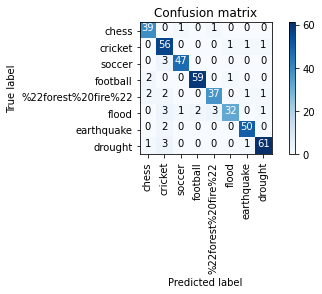

Multiclass SVM OvR TFIDF Accuracy Score: 0.9180722891566265
Multiclass SVM OvR TFIDF Recall Score: 0.9180722891566265
Multiclass SVM OvR TFIDF Precision Score: 0.9180722891566265
Multiclass SVM OvR TFIDF f1 Score: 0.9180722891566265
Multiclass SVM OvR LSI Confusion matrix: 

Confusion matrix, without normalization
[[40  0  0  0  1  0  0  0]
 [ 0 53  0  0  3  1  1  1]
 [ 0  3 47  0  0  0  0  0]
 [ 1  0  0 60  0  1  0  0]
 [ 1  0  0  1 37  2  1  1]
 [ 0  2  1  4  3 31  0  1]
 [ 0  1  0  1  0  0 50  0]
 [ 1  2  0  1  0  0  1 61]]


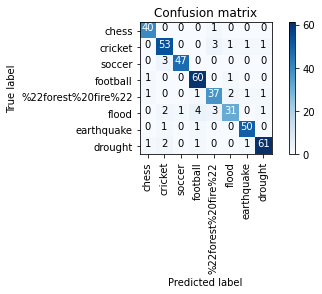

Multiclass SVM OvR LSI Accuracy Score: 0.9132530120481928
Multiclass SVM OvR LSI Recall Score: 0.9132530120481928
Multiclass SVM OvR LSI Precision Score: 0.9132530120481928
Multiclass SVM OvR LSI f1 Score: 0.9132530120481928
Multiclass SVM OvR NMF Confusion matrix: 

Confusion matrix, without normalization
[[38  2  0  0  0  1  0  0]
 [ 0 51  1  0  4  2  1  0]
 [ 0  2 47  0  0  0  1  0]
 [ 2  1  0 57  1  1  0  0]
 [ 1  3  0  2 31  5  1  0]
 [ 2  2  1  3  4 29  0  1]
 [ 1  1  0  0  0  0 50  0]
 [ 1  3  0  0  1  1  2 58]]


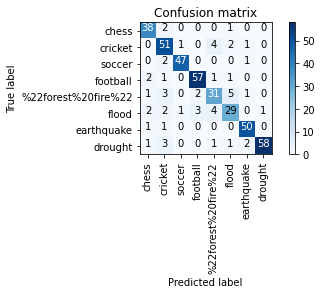

Multiclass SVM OvR NMF Accuracy Score: 0.8698795180722891
Multiclass SVM OvR NMF Recall Score: 0.8698795180722891
Multiclass SVM OvR NMF Precision Score: 0.8698795180722891
Multiclass SVM OvR NMF f1 Score: 0.8698795180722891


In [59]:
labels = ['TFIDF', 'LSI', 'NMF'] # , 'LSI', 'NMF'
classes = ['chess', "cricket", "soccer","football","%22forest%20fire%22","flood","earthquake",'drought']
for idx, x in enumerate(X_multi_train):
    if (idx < len(labels)):
        # train model
        multiclass_svm_OvR.fit(x, y_multi_train)
        # get test results
        multiclass_svm_OvR_pred = multiclass_svm_OvR.predict(X_multi_test[idx])
        multiclass_svm_OvR_confusion = confusion_matrix(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred)
        multiclass_svm_OvR_accuracy = accuracy_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred)
        multiclass_svm_OvR_recall = recall_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred, average='micro')
        multiclass_svm_OvR_precision = precision_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred, average='micro')
        multiclass_svm_OvR_f1 = f1_score(y_true=y_multi_test, y_pred=multiclass_svm_OvR_pred, average='micro')
        print("Multiclass SVM OvR " + labels[idx] + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(multiclass_svm_OvR_confusion, classes = classes)
        print("Multiclass SVM OvR " + labels[idx] + " Accuracy Score: " + str(multiclass_svm_OvR_accuracy))
        print("Multiclass SVM OvR " + labels[idx] + " Recall Score: " + str(multiclass_svm_OvR_recall))
        print("Multiclass SVM OvR " + labels[idx] + " Precision Score: " + str(multiclass_svm_OvR_precision))
        print("Multiclass SVM OvR " + labels[idx] + " f1 Score: " + str(multiclass_svm_OvR_f1))